# This file is seeing what we get when we just apply the Random Forest directly to the Time Series

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
from rfgap import RFGAP


# Get the data
sys.path.insert(0, '/yunity/arusty/PF-GAP')

static2025 = pd.read_csv('../data/static2025.csv')
static2022 = pd.read_csv('../data/static2022.csv')
static2024 = pd.read_csv('../data/static2024.csv')
static2023 = pd.read_csv('../data/static2023.csv')
time_series = pd.read_csv('../data/time_series.csv')
labels = pd.read_csv('../data/labels.csv')


In [2]:
# Combine the static data with the time series data
static2024.shape, time_series.shape

((496, 11), (496, 829))

In [3]:
train = np.concat([time_series, static2024], axis=1)
train.shape

(496, 840)

In [4]:
rfgap = RFGAP(prediction_type="classification", y = labels, oob_score = True)
rfgap.fit(train, labels)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [5]:
rfgap.oob_score_

0.7842741935483871

In [6]:
rfgap.get_proximities().todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00775194],
        [0.00222469, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.03151725,
         0.01583917],
        ...,
        [0.        , 0.00143472, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00105042, 0.00906967, ..., 0.        , 0.        ,
         0.00757123],
        [0.        , 0.00172414, 0.00860533, ..., 0.        , 0.02134647,
         0.        ]])

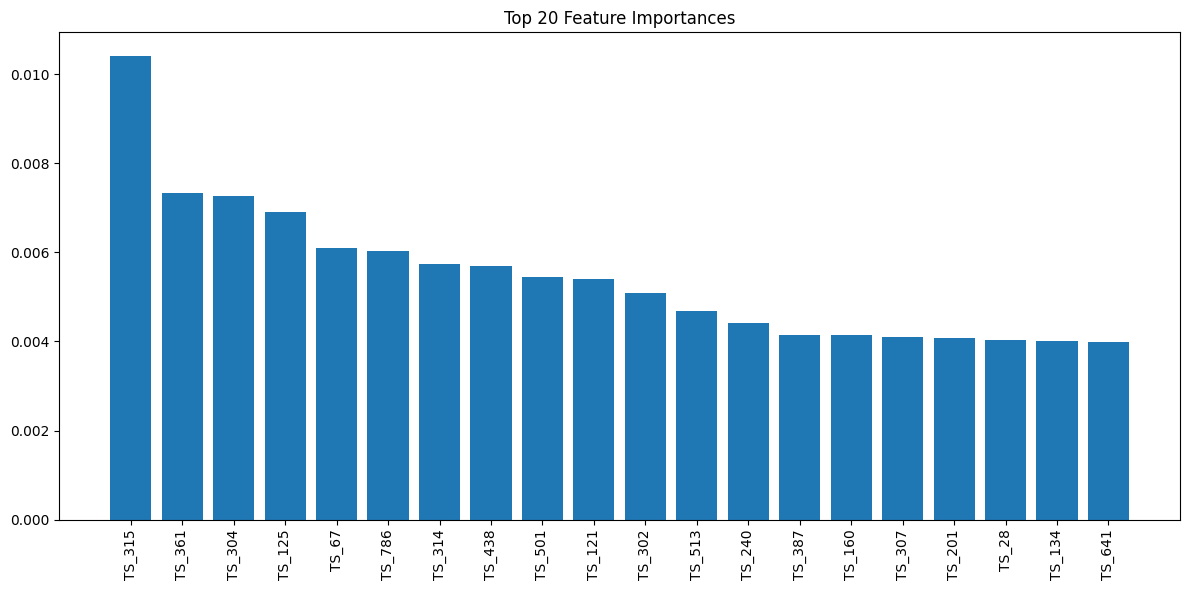

In [7]:
import matplotlib.pyplot as plt

# Get feature importances from the fitted rfgap model
importances = rfgap.feature_importances_

# Create feature names: static + time series
static_features = list(static2024.columns)
time_series_features = [f"TS_{col}" for col in time_series.columns]
feature_names = time_series_features + static_features

# Plot
plt.figure(figsize=(12, 6))
indices = np.argsort(importances)[::-1][:20]  # Top 20 features

# Color bars orange if in the last 11 features, else blue
bar_colors = [
    'orange' if indices[i] >= len(feature_names) - 11 else 'C0'
    for i in range(len(indices))
]

plt.bar(range(len(indices)), importances[indices], color=bar_colors)
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Setting this up to get test results

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test, static2023_train, static2023_test, static2024_train, static2024_test = train_test_split(time_series, 
labels, static2023, static2024, test_size=0.2, random_state=42)

X_train = np.concat([X_train, static2023_train], axis=1)
X_test = np.concat([X_test, static2024_test], axis=1)

# Fit the model on the training set
rfgap.fit(X_train, y_train)

# Optionally, check OOB score or make predictions on X_test
print("OOB Score:", rfgap.oob_score_)
print("Test Set Score:", rfgap.score(X_test, y_test))

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


OOB Score: 0.7651515151515151
Test Set Score: 0.78


In [9]:
prox_train = np.array(rfgap.get_proximities().todense())
prox_test = np.array(rfgap.prox_extend(X_test).todense())

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Use the proximity matrices as features for KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(prox_train, y_train)
knn.score(prox_test, y_test)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.71

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pandas as pd

time_series = np.array(pd.read_csv('../data/time_series.csv'))

def determine_static(fold):
    if fold < 2:
        static_train = static2022
        static_test = static2023
    elif fold < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    return np.array(static_train), np.array(static_test)

# Prepare y as 1D array for sklearn compatibility
y = labels['Labels'].values

# Set up cross-validation
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(time_series, y)):
    # Split data
    X_train, X_test = time_series[train_idx], time_series[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    
    static_train, static_test = determine_static(fold)

    X_train = np.concat([X_train, static_train[train_idx]], axis=1)
    X_test = np.concat([X_test, static_test[test_idx]], axis=1)
    
    # Fit Random Forest
    rfgap.fit(X_train, y_train_fold)
    y_pred_rf = rfgap.predict(X_test)
    
    # Proximity matrices for KNN
    prox_train = np.array(rfgap.get_proximities().todense())
    prox_test = np.array(rfgap.prox_extend(X_test).todense())
    
    # Fit KNN on proximities
    knn.fit(prox_train, y_train_fold)
    knn_acc = knn.score(prox_test, y_test_fold)
    
    # RF metrics
    rf_f1 = f1_score(y_test_fold, y_pred_rf, average='weighted')
    rf_recall = recall_score(y_test_fold, y_pred_rf, average='weighted')
    rf_precision = precision_score(y_test_fold, y_pred_rf, average='weighted')
    rf_acc = accuracy_score(y_test_fold, y_pred_rf)
    
    results.append({
        'fold': fold,
        # 'train_idx': train_idx,
        # 'test_idx': test_idx,
        'knn_accuracy': knn_acc,
        'rf_f1': rf_f1,
        'rf_recall': rf_recall,
        'rf_precision': rf_precision,
        'rf_accuracy': rf_acc
    })

# Convert results to DataFrame
cv_results = pd.DataFrame(results)
cv_results

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

,fold,knn_accuracy,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,0.674699,0.794206,0.807229,0.802610,0.807229
1,1,0.686747,0.799533,0.819277,0.809244,0.819277
2,2,0.734940,0.827318,0.843373,0.839670,0.843373
3,3,0.722892,0.726900,0.746988,0.731180,0.746988
4,4,0.768293,0.814450,0.829268,0.845641,0.829268
5,5,0.756098,0.777086,0.792683,0.818191,0.792683
